In [ ]:
import imgtools as im
import SimpleITK as sitk
import numpy as np
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Any

from typing import Union, Sequence, Optional
# from .functional import *
from imgtools.ops.functional import (
    bounding_box,
    centroid,
    clip_intensity,
    crop,
    crop_to_mask_bounding_box,
    image_statistics,
    min_max_scale,
    resample,
    resize,
    rotate,
    standard_scale,
    window_intensity,
    zoom,
)
from pathlib import Path
from imgtools.io.loaders import read_dicom_auto


In [12]:

@dataclass
class BaseOp(ABC):
    """
    A base class for operations with enforced abstract method implementation.

    Attributes
    ----------
    example_field : str
        An example field with a default value, which can be customized.
    """
    @abstractmethod
    def __call__(self, *args: Any, **kwargs: Any) -> Any:  # noqa
        """
        Execute the operation. This method must be implemented by subclasses.

        Parameters
        ----------
        *args : Any
            Positional arguments for the operation.
        **kwargs : Any
            Keyword arguments for the operation.

        Returns
        -------
        Any
            The result of the operation.

        Raises
        ------
        NotImplementedError
            If the method is not implemented in the subclass.
        """
        msg = "Subclasses must implement this method."
        raise NotImplementedError(msg)

@dataclass
class Resample(BaseOp):
	"""
	A callable class that resamples an image to a given spacing, optionally applying a transformation.

	Attributes
	----------
	spacing : Union[float, Sequence[float], np.ndarray]
		The new image spacing. If float, assumes the same spacing in all
		directions. Alternatively, a sequence of floats can be passed to
		specify spacing along each dimension. Passing 0 at any position will
		keep the original spacing along that dimension (useful for in-plane
		resampling).
	interpolation : str, optional
		The interpolation method to use. Valid options are:
		- "linear" for bi/trilinear interpolation (default)
		- "nearest" for nearest neighbour interpolation
		- "bspline" for order-3 b-spline interpolation
	anti_alias : bool, optional
		Whether to smooth the image with a Gaussian kernel before resampling.
		Only used when downsampling, i.e., when `spacing < image.GetSpacing()`.
	anti_alias_sigma : Optional[float], optional
		The standard deviation of the Gaussian kernel used for anti-aliasing.
	transform : Optional[sitk.Transform], optional
		Transform to apply to input coordinates when resampling. If None,
		defaults to identity transformation.
	output_size : Optional[Sequence[float]], optional
		Size of the output image. If None, it is computed to preserve the
		whole extent of the input image.
	"""
	spacing: Union[float, Sequence[float], np.ndarray]
	interpolation: str = "linear"
	anti_alias: bool = True
	anti_alias_sigma: Optional[float] = None
	transform: Optional[sitk.Transform] = None
	output_size: Optional[Sequence[float]] = None

	def __call__(self, image: sitk.Image) -> sitk.Image:
		"""
		Resample callable object: Resamples an image to a given spacing, optionally applying a transformation.

		Parameters
		----------
		image : sitk.Image
			The image to resample.

		Returns
		-------
		sitk.Image
			The resampled image.
		"""
		return resample(
			image,
			spacing=self.spacing,
			interpolation=self.interpolation,
			anti_alias=self.anti_alias,
			anti_alias_sigma=self.anti_alias_sigma,
			transform=self.transform,
			output_size=self.output_size,
		)



In [21]:
ct = Path("/Users/bhklab/dev/radiomics/med-imagetools/TRASH/data/images/HN-CHUS-082/StudyUID-06980/CT_SeriesUID-05195")
rt = Path("/Users/bhklab/dev/radiomics/med-imagetools/TRASH/data/images/HN-CHUS-082/StudyUID-06980/RTSTRUCT_SeriesUID-67882/1-1.dcm")



In [22]:
ct_image = read_dicom_auto(ct.as_posix())
ct_image.metadata


{'DataCollectionDiameter': '500',
 'SliceThickness': '3.00',
 'PatientPosition': 'HFS',
 'Manufacturer': 'Philips',
 'ScanOptions': 'HELIX',
 'RescaleSlope': '1',
 'ManufacturerModelName': 'GeminiGXL 16',
 'PixelSize': "('1.171875', '1.171875', '3.00')",
 'KVP': '140',
 'XRayTubeCurrent': '394',
 'ReconstructionDiameter': '600',
 'ConvolutionKernel': 'C'}

In [23]:
rt_image = read_dicom_auto(rt.as_posix())
rt_image.metadata

2024-12-09T13:59:57-0500 [warning  ] Could not get points for ROI `GTV2`. [imgtools] call=structureset.from_dicom_rtstruct:48 error=AttributeError("'Dataset' object has no attribute 'ContourSequence'") rtstruct_path=/Users/bhklab/dev/radiomics/med-imagetools/TRASH/data/images/HN-CHUS-082/StudyUID-06980/RTSTRUCT_SeriesUID-67882/1-1.dcm
2024-12-09T13:59:57-0500 [warning  ] Could not get points for ROI `GANGLION1`. [imgtools] call=structureset.from_dicom_rtstruct:48 error=AttributeError("'Dataset' object has no attribute 'ContourSequence'") rtstruct_path=/Users/bhklab/dev/radiomics/med-imagetools/TRASH/data/images/HN-CHUS-082/StudyUID-06980/RTSTRUCT_SeriesUID-67882/1-1.dcm
2024-12-09T13:59:57-0500 [warning  ] Could not get points for ROI `GANGLION2`. [imgtools] call=structureset.from_dicom_rtstruct:48 error=AttributeError("'Dataset' object has no attribute 'ContourSequence'") rtstruct_path=/Users/bhklab/dev/radiomics/med-imagetools/TRASH/data/images/HN-CHUS-082/StudyUID-06980/RTSTRUCT_Ser

{'Manufacturer': 'ADAC',
 'ManufacturerModelName': 'Pinnacle3',
 'numROIs': '171'}

In [32]:
print(f"{ct_image.image.GetSize()=}")
print(f"{ct_image.image.GetSpacing()=}")


ct_image.image.GetSize()=(512, 512, 134)
ct_image.image.GetSpacing()=(1.171875, 1.171875, 3.0)


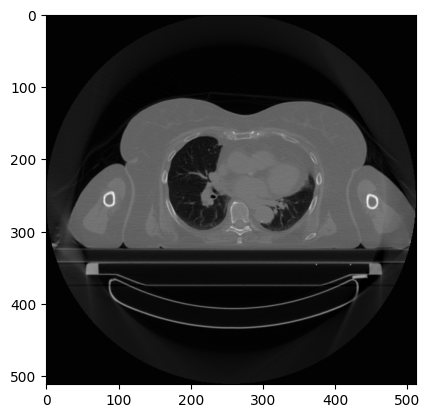

In [ ]:
new_ct = Resample(spacing=(0, 0., 0.))(ct_image.image)
new_ct.GetSize()

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
image_array = sitk.GetArrayFromImage(new_ct)
ax.imshow(image_array[0], cmap='gray')
plt.show()